In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

load_dotenv()

OPENAI_API_BASE = os.environ.get("OPENAI_API_BASE")
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

LANGCHAIN_TRACING_V2 = os.environ.get("LANGCHAIN_TRACING_V2")
LANGCHAIN_ENDPOINT = 'https://api.smith.langchain.com'
LANGCHAIN_API_KEY = os.environ.get("LANGCHAIN_API_KEY")

TAVILY_API_KEY = os.environ.get("TAVILY_API_KEY")

llm = ChatOpenAI(model="qwen-max", temperature=0)

model_name = "C:\\Home\\Documents\\Projects\\models\\BAAI\\bge-large-en-v1.5"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
embedding_model = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

c:\Apps\miniconda3\envs\rag\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Vector Store

from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient

client = QdrantClient(host="localhost", port=6333)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="rag_from_scratch",
    embedding=embedding_model,
)

retriever = vector_store.as_retriever(k=4)

# Retrieval Grader

In [3]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION. 
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"],
)

llm = ChatOpenAI(model="qwen-max", temperature=0)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))

{'score': 'yes'}


# Generate

In [4]:
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

Agent memory includes short-term and long-term components. Short-term memory involves in-context learning, while long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store for fast retrieval. Recency, importance, and relevance are key factors in determining which memories are surfaced to inform the agent's behavior.


# Search

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [6]:
web_search_tool.invoke("What's the weather in Hefei on 2025-01-26?")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Hefei', 'region': 'Anhui', 'country': 'China', 'lat': 31.8639, 'lon': 117.2808, 'tz_id': 'Asia/Shanghai', 'localtime_epoch': 1737902062, 'localtime': '2025-01-26 22:34'}, 'current': {'last_updated_epoch': 1737901800, 'last_updated': '2025-01-26 22:30', 'temp_c': 1.1, 'temp_f': 34.0, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 16.8, 'wind_kph': 27.0, 'wind_degree': 314, 'wind_dir': 'NW', 'pressure_mb': 1031.0, 'pressure_in': 30.45, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 59, 'cloud': 0, 'feelslike_c': -4.7, 'feelslike_f': 23.5, 'windchill_c': -4.5, 'windchill_f': 23.9, 'heatindex_c': 1.3, 'heatindex_f': 34.3, 'dewpoint_c': -9.4, 'dewpoint_f': 15.1, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 0.0, 'gust_mph': 26.7, 'gust_kph': 42.9}}"},
 {'url': 'https://www.easeweather.com/asia/china/anhui/hefei-shi/hefei/january',
  'con

# Create the Graph

In [7]:
from typing import List, TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph

In [8]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]

In [9]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    
    return {"documents": documents, "question": question, "steps": steps}

In [10]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }

In [11]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }

In [12]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    
    return {"documents": documents, "question": question, "steps": steps}

In [13]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"

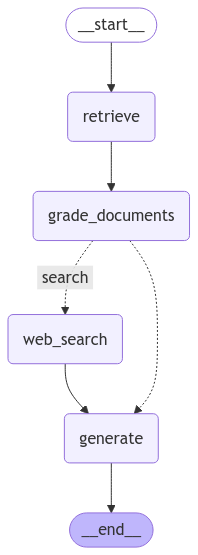

In [14]:
# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [15]:
import uuid

def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": "What are the types of agent memory?"}
response = predict_custom_agent_local_answer(example)
response

{'response': 'The types of agent memory include sensory memory, short-term or working memory, and long-term memory. Short-term memory is used for in-context learning and lasts for a brief period, while long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'generate_answer']}

In [17]:
example = {"input": "Explain how DeepSeek-R1 work?"}
response = predict_custom_agent_local_answer(example)
response

{'response': 'DeepSeek-R1 is trained using only reinforcement learning, without any supervised fine-tuning, to develop its reasoning capabilities. It was presented with a variety of reasoning tasks during training, from math problems to abstract logic challenges, to generate structured chains of thought. This approach demonstrates that reinforcement learning alone can produce a model with high-performing reasoning abilities.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}